# Data Preperation

### Importing Necessary Libraries

In [83]:
import os # For directory and file manipulation
import shutil # For high-level file operations like copying and removal
import pandas as pd # For data manipulation and analysis
from tqdm import tqdm # For displaying a progress bar
import rasterio # For working with raster data (e.g., satellite imagery)
from rasterio.plot import show # For displaying raster data
import numpy as np # For numerical operations on arrays
import matplotlib.pyplot as plt # For plotting data and images
import seaborn as sns
import textwrap
from PIL import Image
import random

### Loading Metadata and Defining Base Directories

In [74]:
# Load the metadata
metadata_df = pd.read_parquet(r'C:\Users\isaac\Downloads\metadata.parquet')
# Base directories
source_base_dir = r'D:\datasets\2020-BigEarthNet-S2'
destination_base_dir = r'D:\datasets\2020-BigEarthNet-S2\BigEarthNetDataset'

### Inspecting the Meta Data

In [3]:
num_rows = metadata_df.shape[0]
print(f"The DataFrame contains {num_rows} rows.")

print()

# Display the column names
print("Column Names:")
print(metadata_df.columns)

print()

# Display the first few rows of the DataFrame
print("First few rows of the DataFrame:")
print(metadata_df.head())

The DataFrame contains 480038 rows.

Column Names:
Index(['patch_id', 'labels', 'split', 'country', 's1_name', 's2v1_name',
       'contains_seasonal_snow', 'contains_cloud_or_shadow'],
      dtype='object')

First few rows of the DataFrame:
                                            patch_id  \
0  S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...   
1  S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...   
2  S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...   
3  S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...   
4  S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...   

                                              labels split  country  \
0  [Arable land, Broad-leaved forest, Mixed fores...  test  Austria   
1  [Arable land, Broad-leaved forest, Inland wate...  test  Austria   
2  [Arable land, Broad-leaved forest, Coniferous ...  test  Austria   
3  [Broad-leaved forest, Complex cultivation patt...  test  Austria   
4  [Broad-leaved forest, Complex cultivation patt...  test  Austri

### Extracting Unique Labels and Creating Directories

In [4]:
# Extract unique labels from the metadata
unique_labels = metadata_df['labels'].explode().unique()

# Print the unique labels in a numbered table format
print("Unique Labels:")
for i, label in enumerate(unique_labels, start=1):
    print(f"{i}. {label}")

print()

# Create directories for each label with progress bar
for label in tqdm(unique_labels, desc="Creating directories"):
    label_dir = os.path.join(destination_base_dir, label)
    
    # Create the directory if it does not exist
    if not os.path.exists(label_dir):
        os.makedirs(label_dir)

print("All directories have been created.")

Unique Labels:
1. Arable land
2. Broad-leaved forest
3. Mixed forest
4. Pastures
5. Inland waters
6. Coniferous forest
7. Complex cultivation patterns
8. Land principally occupied by agriculture, with significant areas of natural vegetation
9. Urban fabric
10. Industrial or commercial units
11. Inland wetlands
12. Transitional woodland, shrub
13. Natural grassland and sparsely vegetated areas
14. Moors, heathland and sclerophyllous vegetation
15. Marine waters
16. Coastal wetlands
17. Permanent crops
18. Beaches, dunes, sands
19. Agro-forestry areas



Creating directories: 100%|██████████| 19/19 [00:00<00:00, 1807.77it/s]

All directories have been created.


### Converting Labels to Binary Vectors and Saving MetaData

In [5]:
# Extract unique labels from the metadata and sort
unique_labels = metadata_df['labels'].explode().unique()
all_labels = sorted(unique_labels)  # Ensure all_labels is sorted

# Create a dictionary to map label names to indices
label_to_index = {label: i for i, label in enumerate(all_labels)}

# Function to convert label list to binary vector
def labels_to_vector(label_list):
    vector = [0] * len(all_labels)
    for label in label_list:
        index = label_to_index[label]
        vector[index] = 1
    return vector

# Apply the conversion to the 'labels' column
metadata_df['label_vector'] = metadata_df['labels'].apply(labels_to_vector)

# Save the updated DataFrame with the label_vector to a Parquet file
metadata_df.to_parquet('updated_metadata_with_vectors.parquet', index=False)

### Loading and Inspecting Updated Meta Data

In [7]:
updated_metadata_df = pd.read_parquet(r'C:\Users\isaac\FYPCode\updated_metadata_with_vectors.parquet')

num_rows = updated_metadata_df.shape[0]
print(f"The DataFrame contains {num_rows} rows.")

print()

# Display the column names
print("Column Names:")
print(updated_metadata_df.columns)

print()

# Display the first few rows of the DataFrame
print("First few rows of the DataFrame:")
print(updated_metadata_df.head())

The DataFrame contains 480038 rows.

Column Names:
Index(['patch_id', 'labels', 'split', 'country', 's1_name', 's2v1_name',
       'contains_seasonal_snow', 'contains_cloud_or_shadow', 'label_vector'],
      dtype='object')

First few rows of the DataFrame:
                                            patch_id  \
0  S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...   
1  S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...   
2  S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...   
3  S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...   
4  S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...   

                                              labels split  country  \
0  [Arable land, Broad-leaved forest, Mixed fores...  test  Austria   
1  [Arable land, Broad-leaved forest, Inland wate...  test  Austria   
2  [Arable land, Broad-leaved forest, Coniferous ...  test  Austria   
3  [Broad-leaved forest, Complex cultivation patt...  test  Austria   
4  [Broad-leaved forest, Complex cultivation patt.

In [7]:
# Function to process each image
def process_image(image_folder_path, labels):
    try:
        # Process each label
        for label in labels:
            dest_dir = os.path.join(destination_base_dir, label)

            # Create the directory if it does not exist
            if not os.path.exists(dest_dir):
                os.makedirs(dest_dir, exist_ok=True)

            # Construct the destination path for each label
            dest_folder_path = os.path.join(dest_dir, os.path.basename(image_folder_path))

            # Check if the destination folder already exists
            if not os.path.exists(dest_folder_path):
                # Copy the folder
                shutil.copytree(image_folder_path, dest_folder_path)

        # Remove the source directory after copying all the labels
        shutil.rmtree(image_folder_path)
    except Exception as e:
        print(f"Error processing folder {image_folder_path}: {e}")

# Count total images to process, excluding 'BigEarthNetDataset'
total_images = 0
for date_folder in os.listdir(source_base_dir):
    if date_folder == 'BigEarthNetDataset':
        continue  # Skip this folder
    date_folder_path = os.path.join(source_base_dir, date_folder)
    if os.path.isdir(date_folder_path):
        image_folders = [f for f in os.listdir(date_folder_path) if os.path.isdir(os.path.join(date_folder_path, f))]
        num_images = len(image_folders)
        total_images += num_images

# Create a progress bar for processing images
with tqdm(total=total_images, desc="Processing Images") as pbar:
    # Iterate through each date folder
    for date_folder in os.listdir(source_base_dir):
        if date_folder == 'BigEarthNetDataset':
            continue  # Skip this folder
        date_folder_path = os.path.join(source_base_dir, date_folder)
        
        if os.path.isdir(date_folder_path):
            # Iterate through each image folder within the date folder
            for image_folder in os.listdir(date_folder_path):
                image_folder_path = os.path.join(date_folder_path, image_folder)
                
                if os.path.isdir(image_folder_path):
                    # Find the corresponding metadata row
                    patch_id = image_folder
                    row = metadata_df[metadata_df['patch_id'] == patch_id]
                    
                    if not row.empty:
                        labels = row.iloc[0]['labels']
                        process_image(image_folder_path, labels)
                    
                    # Update progress bar after processing each image
                    pbar.update(1)

print("Processing complete.")

Processing Images: 100%|██████████| 422728/422728 [10:04:23<00:00, 11.66it/s]  


Processing complete.


In [39]:
# Initialize a dictionary to hold the count of subfolders in each folder
folder_subfolder_counts = {}

# Iterate through each item in the base directory with a progress bar
for folder in tqdm(os.listdir(destination_base_dir), desc="Processing Folders", unit="folder"):
    folder_path = os.path.join(destination_base_dir, folder)
    
    # Check if the path is a directory
    if os.path.isdir(folder_path):
        # List all subdirectories within the current folder
        subfolders = [subfolder for subfolder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, subfolder))]
        
        # Count the number of subfolders
        subfolder_count = len(subfolders)
        
        # Store the count in the dictionary
        folder_subfolder_counts[folder] = subfolder_count

# Convert dictionary to DataFrame
df_folder_counts = pd.DataFrame(list(folder_subfolder_counts.items()), columns=['Folder', 'Subfolder Count'])

# Sort the DataFrame by 'Subfolder Count' in descending order
df_folder_counts = df_folder_counts.sort_values(by='Subfolder Count', ascending=False)

# Print header
print(f"{'Folder Name':<70} {'Subfolder Count':>15}")
print("-" * 85)

# Print the sorted number of subfolders in each folder in a formatted manner
for folder, count in df_folder_counts.itertuples(index=False):
    print(f"{folder:<70} {count:>15}")

Processing Folders: 100%|██████████| 19/19 [05:29<00:00, 17.34s/folder]

Folder Name                                                            Subfolder Count
-------------------------------------------------------------------------------------
Arable land                                                                     188025
Mixed forest                                                                    165780
Coniferous forest                                                               154941
Transitional woodland, shrub                                                    141150
Broad-leaved forest                                                             135928
Land principally occupied by agriculture, with significant areas of natural vegetation          122709
Complex cultivation patterns                                                     99598
Pastures                                                                         95605
Urban fabric                                                                     63758
Inland waters               

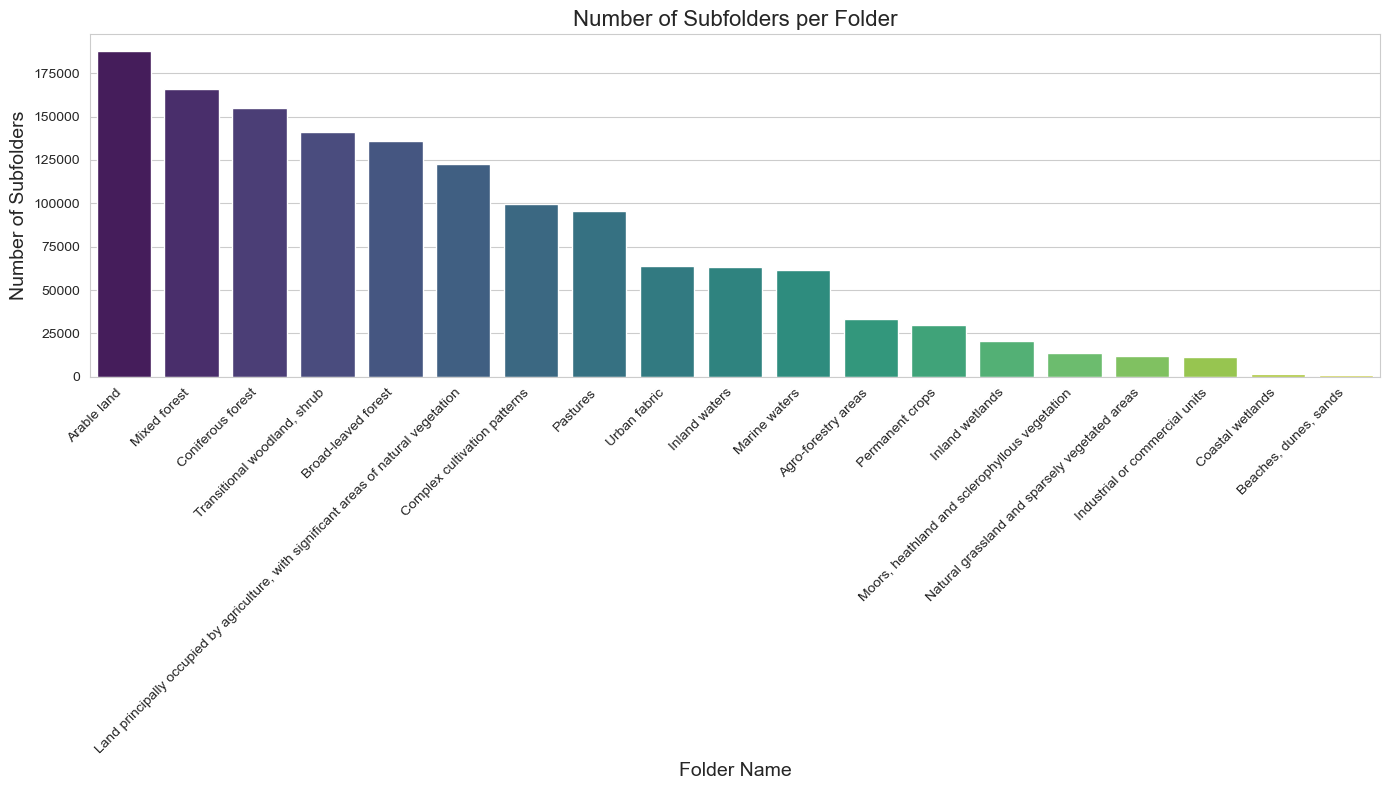

In [60]:
# Create the bar plot
plt.figure(figsize=(14, 8))
sns.barplot(x='Folder', y='Subfolder Count', data=df_folder_counts, hue='Folder', palette='viridis', legend=False)

# Add titles and labels
plt.title('Number of Subfolders per Folder', fontsize=16)
plt.xlabel('Folder Name', fontsize=14)
plt.ylabel('Number of Subfolders', fontsize=14)

# Rotate and wrap the x-axis labels
plt.xticks(rotation=45, ha="right")  # Rotate labels by 45 degrees and align them right
ax = plt.gca()  # Get the current Axes object
for label in ax.get_xticklabels():
    label.set_text("\n".join(textwrap.wrap(label.get_text(), width=15)))  # Wrap each label's text

# Show the plot
plt.tight_layout() 

# Create the 'images' folder if it doesn't exist
if not os.path.exists('images'):
    os.makedirs('images')

# Save the plot within the 'images' folder
plt.savefig('images/original_categories_barplot.png')  
plt.show()

In [69]:
num_rows = updated_metadata_df.shape[0]
print(f"The DataFrame contains {num_rows} rows.")

print()

# Convert numpy.ndarray to list if necessary
updated_metadata_df['labels'] = updated_metadata_df['labels'].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

# Count the number of labels per record
updated_metadata_df['label_count'] = updated_metadata_df['labels'].apply(len)

# Get the counts for each label count
single_label_count = updated_metadata_df[updated_metadata_df['label_count'] == 1].shape[0]
two_labels_count = updated_metadata_df[updated_metadata_df['label_count'] == 2].shape[0]
three_labels_count = updated_metadata_df[updated_metadata_df['label_count'] == 3].shape[0]
four_labels_count = updated_metadata_df[updated_metadata_df['label_count'] == 4].shape[0]
five_labels_count = updated_metadata_df[updated_metadata_df['label_count'] == 5].shape[0]
six_labels_count = updated_metadata_df[updated_metadata_df['label_count'] == 6].shape[0]
seven_labels_count = updated_metadata_df[updated_metadata_df['label_count'] == 7].shape[0]
eight_labels_count = updated_metadata_df[updated_metadata_df['label_count'] == 8].shape[0]
nine_labels_count = updated_metadata_df[updated_metadata_df['label_count'] == 9].shape[0]
ten_labels_count = updated_metadata_df[updated_metadata_df['label_count'] == 10].shape[0]
more_than_ten_labels_count = updated_metadata_df[updated_metadata_df['label_count'] > 10].shape[0]

# Print the results
print(f"Number of records with a single label: {single_label_count}")
print(f"Number of records with 2 labels: {two_labels_count}")
print(f"Number of records with 3 labels: {three_labels_count}")
print(f"Number of records with 4 labels: {four_labels_count}")
print(f"Number of records with 5 labels: {five_labels_count}")
print(f"Number of records with 6 labels: {six_labels_count}")
print(f"Number of records with 7 labels: {seven_labels_count}")
print(f"Number of records with 8 labels: {eight_labels_count}")
print(f"Number of records with 9 labels: {nine_labels_count}")
print(f"Number of records with 10 labels: {ten_labels_count}")
print(f"Number of records with more than 10 labels: {more_than_ten_labels_count}")

print()

# Calculate the total number of records
total_records = (single_label_count + two_labels_count + three_labels_count +
                 four_labels_count + five_labels_count + six_labels_count +
                 seven_labels_count + eight_labels_count + nine_labels_count +
                 ten_labels_count + more_than_ten_labels_count)

# Print the total number of records
print(f"Total number of records: {total_records}")

The DataFrame contains 480038 rows.

Number of records with a single label: 86375
Number of records with 2 labels: 94649
Number of records with 3 labels: 135885
Number of records with 4 labels: 102036
Number of records with 5 labels: 45329
Number of records with 6 labels: 12963
Number of records with 7 labels: 2478
Number of records with 8 labels: 302
Number of records with 9 labels: 15
Number of records with 10 labels: 1
Number of records with more than 10 labels: 5

Total number of records: 480038


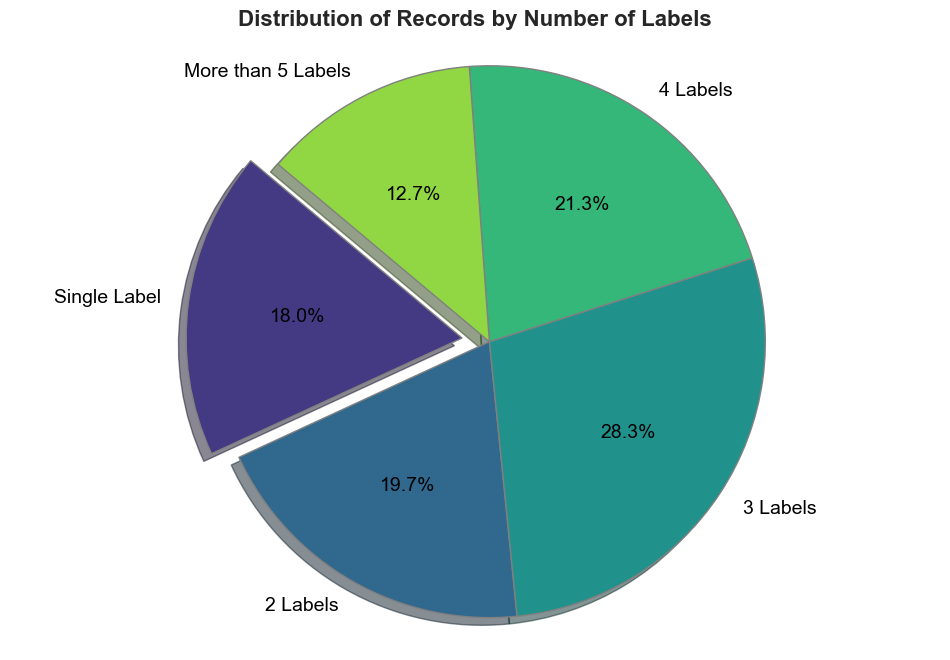

In [62]:
# Set Seaborn style 
sns.set_style("whitegrid")

# Data for the pie chart (assuming you have these variables already defined)
sizes = [single_label_count, two_labels_count, three_labels_count, four_labels_count, more_than_five_labels_count]
labels = ['Single Label', '2 Labels', '3 Labels', '4 Labels', 'More than 5 Labels']

# Use 'viridis' color palette from the first snippet
colors = sns.color_palette('viridis', len(sizes))  # Adjust the number of colors as needed

# Explode the largest segment for emphasis 
explode = (0.1, 0, 0, 0, 0) 

# Create the pie chart - incorporating elements from the first snippet
plt.figure(figsize=(12, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140,
        explode=explode, shadow=True, textprops={'fontsize': 14, 'color': 'black'}, wedgeprops={'edgecolor': 'grey'})

# Title of the pie chart
plt.title('Distribution of Records by Number of Labels', fontsize=16, weight='bold')

# Display the pie chart
plt.axis('equal') 
plt.savefig('images/disribution_of_records_by_labels_piechart')  
plt.show()

In [72]:
# Get the count of records with exactly 1 label that is "Arable land"
one = updated_metadata_df[
    (updated_metadata_df['label_count'] == 1) &
    (updated_metadata_df['labels'].apply(lambda x: x == ['Arable land']))
].shape[0]

print(f"Number of records with exactly 1 label and the label is 'Arable land': {one}")

# Get the count of records with exactly 2 labels that are "Arable land" and "Mixed forest"
two = updated_metadata_df[
    (updated_metadata_df['label_count'] == 2) &
    (updated_metadata_df['labels'].apply(lambda x: set(x) == {'Arable land', 'Mixed forest'}))
].shape[0]

print(f"Number of records with exactly 2 labels 'Arable land' and 'Mixed forest': {two}")

# Get the count of records with exactly 3 labels that are "Arable land", "Mixed forest" and "Coniferous forest"
three = updated_metadata_df[
    (updated_metadata_df['label_count'] == 3) &
    (updated_metadata_df['labels'].apply(lambda x: set(x) == {'Arable land', 'Mixed forest', 'Coniferous forest'}))
].shape[0]

print(f"Number of records with exactly 3 labels 'Arable land', 'Mixed forest' and 'Coniferous forest' : {three}")

# Get the count of records with exactly 3 labels that are "Arable land", "Mixed forest", "Coniferous forest" and "Transitional woodland, shrub"
four = updated_metadata_df[
    (updated_metadata_df['label_count'] == 4) &
    (updated_metadata_df['labels'].apply(lambda x: set(x) == {'Arable land', 'Mixed forest', 'Coniferous forest', 'Transitional woodland, shrub'}))
].shape[0]

print(f"Number of records with exactly 3 labels 'Arable land', 'Mixed forest', 'Coniferous forest' and 'Transitional woodland, shrub': {four}")

five = updated_metadata_df[
    (updated_metadata_df['label_count'] == 5) &
    (updated_metadata_df['labels'].apply(lambda x: set(x) == {'Arable land', 'Mixed forest', 'Coniferous forest', 'Transitional woodland, shrub', 'Broad-leaved forest'}))
].shape[0]

print(f"Number of records with exactly 3 labels 'Arable land', 'Mixed forest', 'Coniferous forest', 'Transitional woodland, shrub' and 'Broad-leaved forest': {five}")


Number of records with exactly 1 label and the label is 'Arable land': 14893
Number of records with exactly 2 labels 'Arable land' and 'Mixed forest': 1507
Number of records with exactly 3 labels 'Arable land', 'Mixed forest' and 'Coniferous forest' : 3815
Number of records with exactly 3 labels 'Arable land', 'Mixed forest', 'Coniferous forest' and 'Transitional woodland, shrub': 3216
Number of records with exactly 3 labels 'Arable land', 'Mixed forest', 'Coniferous forest', 'Transitional woodland, shrub' and 'Broad-leaved forest': 493


In [78]:
print(unique_labels)

['Arable land' 'Broad-leaved forest' 'Mixed forest' 'Pastures'
 'Inland waters' 'Coniferous forest' 'Complex cultivation patterns'
 'Land principally occupied by agriculture, with significant areas of natural vegetation'
 'Urban fabric' 'Industrial or commercial units' 'Inland wetlands'
 'Transitional woodland, shrub'
 'Natural grassland and sparsely vegetated areas'
 'Moors, heathland and sclerophyllous vegetation' 'Marine waters'
 'Coastal wetlands' 'Permanent crops' 'Beaches, dunes, sands'
 'Agro-forestry areas']


Processing category: Arable land
Processing category: Broad-leaved forest
Processing category: Mixed forest
Processing category: Pastures
Processing category: Inland waters
Processing category: Coniferous forest
Processing category: Complex cultivation patterns
Processing category: Land principally occupied by agriculture, with significant areas of natural vegetation
Processing category: Urban fabric
Processing category: Industrial or commercial units
Processing category: Inland wetlands
Processing category: Transitional woodland, shrub
Processing category: Natural grassland and sparsely vegetated areas
Processing category: Moors, heathland and sclerophyllous vegetation
Processing category: Marine waters
Processing category: Coastal wetlands
Processing category: Permanent crops
Processing category: Beaches, dunes, sands
Processing category: Agro-forestry areas


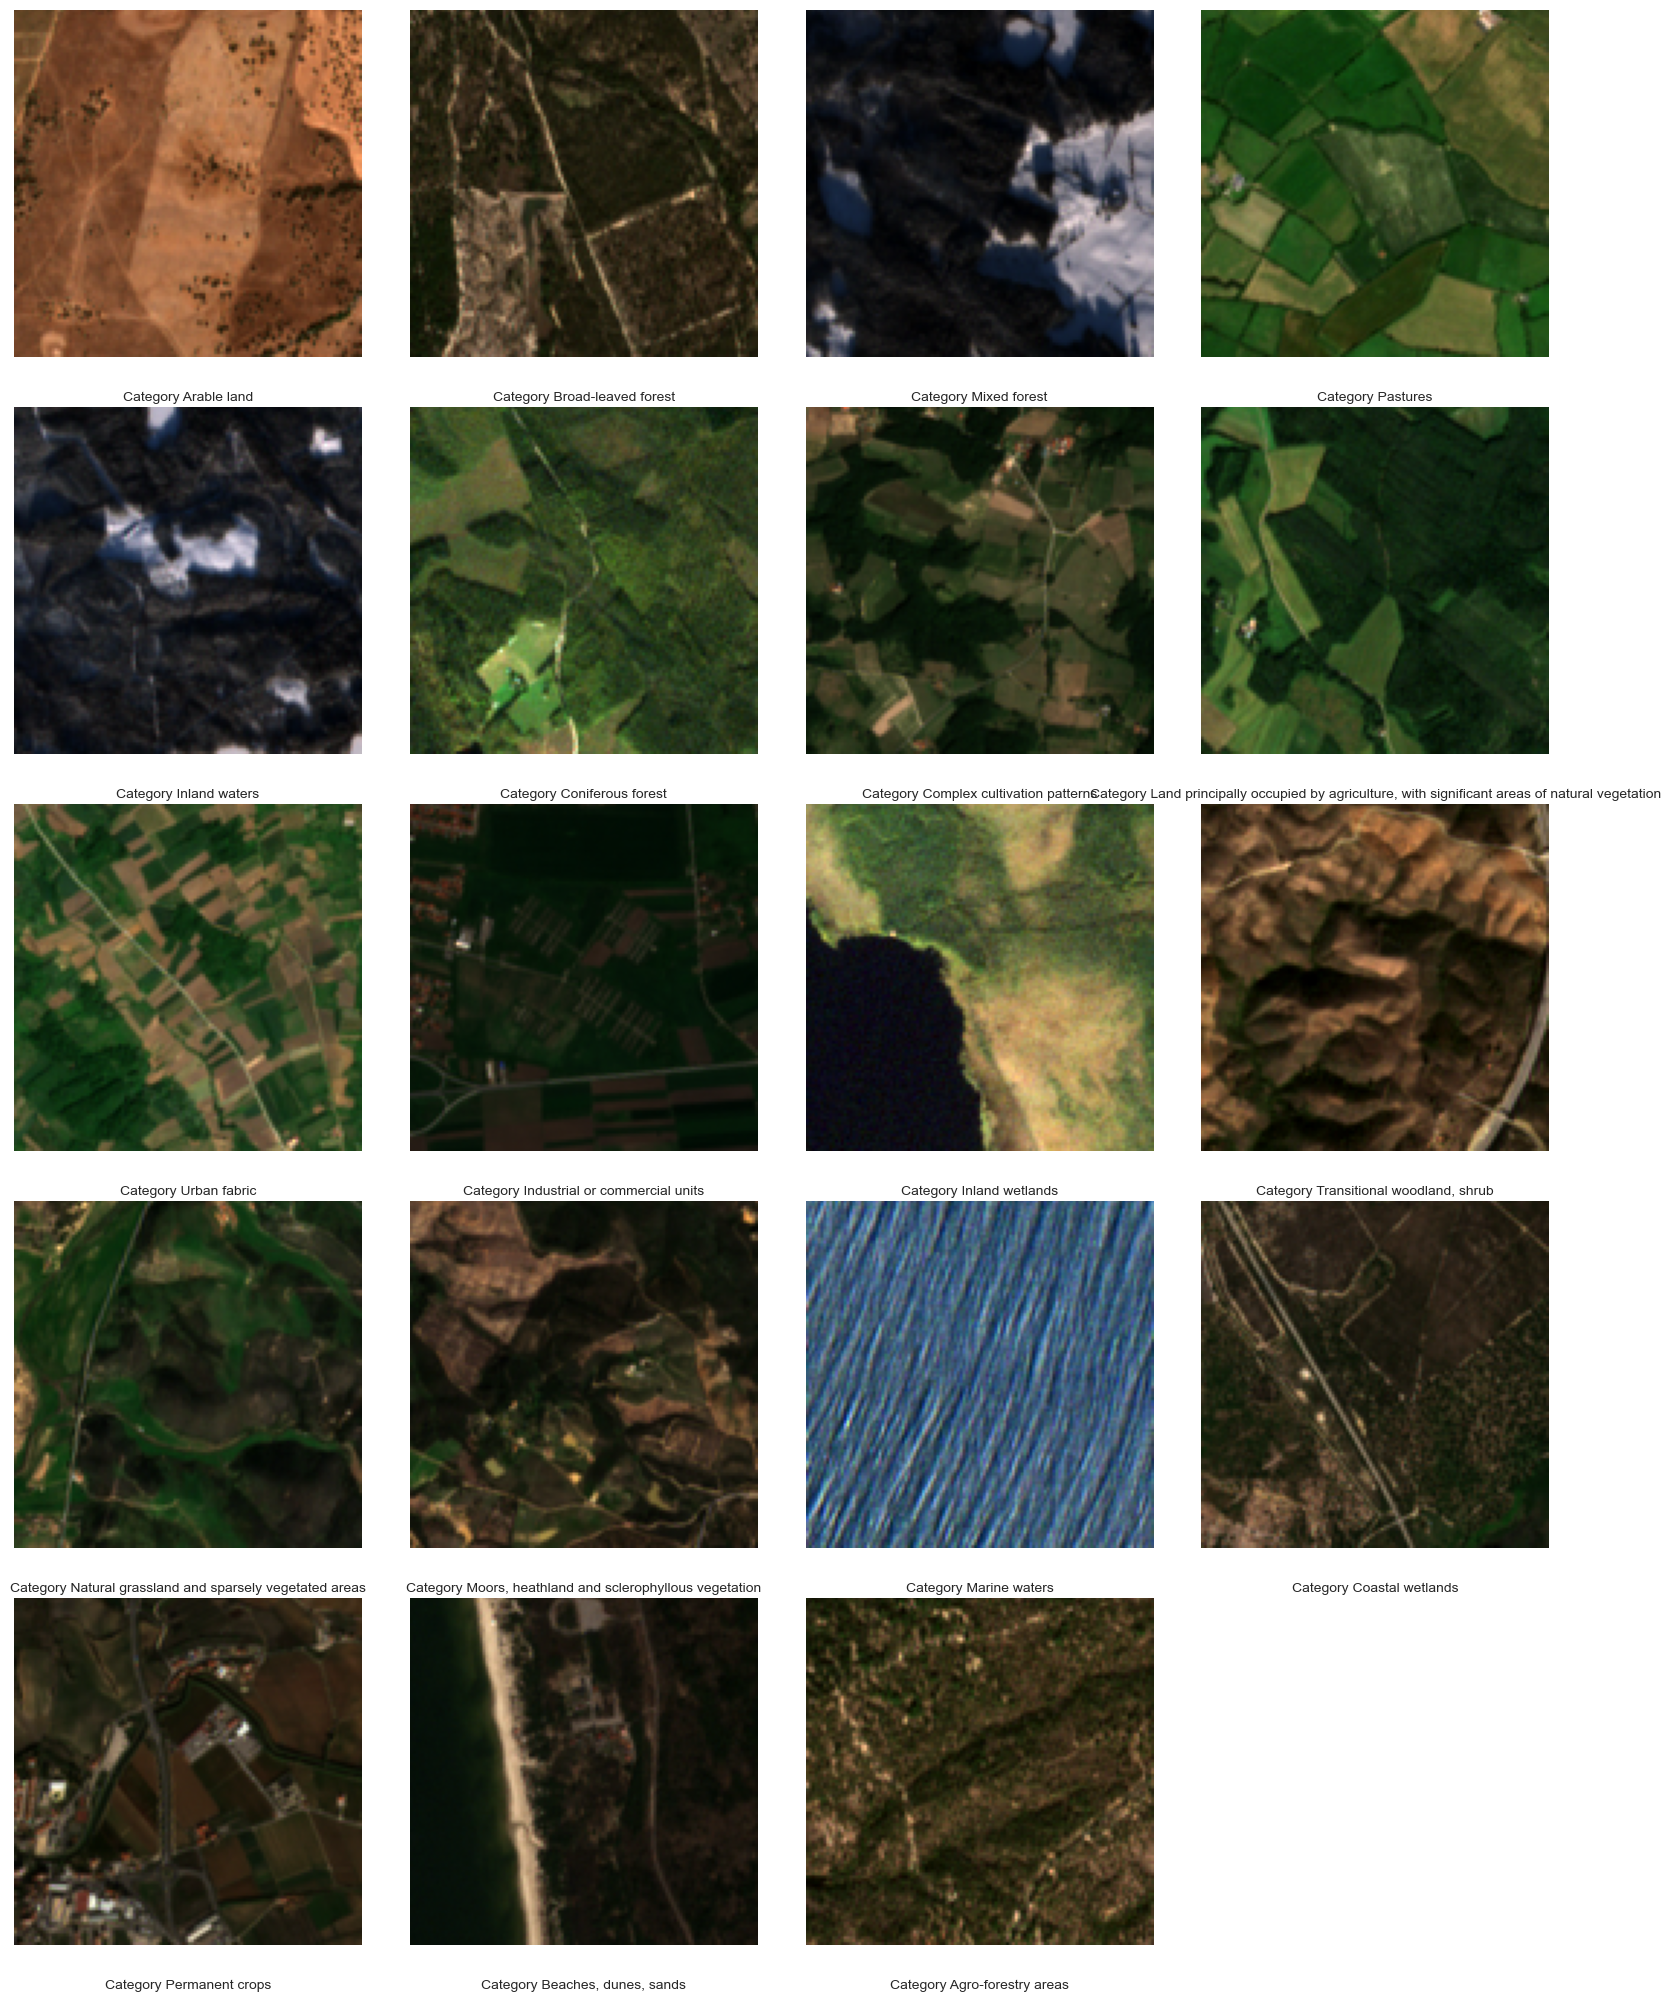

In [93]:
# List to store image paths
image_paths = []

# Iterate over each category
for category in unique_labels:
    print(f"Processing category: {category}")
    
    # Construct the directory path for the current category
    category_path = os.path.join(destination_base_dir, category)
    
    # Check if the directory exists
    if not os.path.exists(category_path):
        print(f"Directory not found: {category_path}")
        continue
    
    # Get the list of folders in the category
    folders = [f for f in os.listdir(category_path) if os.path.isdir(os.path.join(category_path, f))]

    if len(folders) > 0:
        # Select a random folder in the category
        selected_folder = random.choice(folders)
        selected_folder_path = os.path.join(category_path, selected_folder)

        # Collect .tif files in the folder
        tif_files = [file for file in os.listdir(selected_folder_path) if file.lower().endswith('.tif')]
        
        if len(tif_files) >= 4:
            # Sort files to ensure consistent selection of bands
            tif_files.sort()
            # Construct full paths for the second, third, and fourth bands
            band_files = [os.path.join(selected_folder_path, tif_files[i]) for i in range(1, 4)]  # Bands 2, 3, 4
            
            image_paths.append(band_files)
        else:
            print(f"Not enough .tif files in folder: {selected_folder_path}")

# Calculate the number of rows and columns
num_images = len(image_paths)
num_cols = min(4, num_images)  # Set a max number of columns
num_rows = (num_images + num_cols - 1) // num_cols  # Calculate number of rows needed

# Create a figure to display the images
plt.figure(figsize=(num_cols * 4, num_rows * 4))

# Iterate over each set of band files
for i, band_files in enumerate(image_paths, start=1):
    plt.subplot(num_rows, num_cols, i)
    
    try:
        # Read the bands and stack them
        with rasterio.open(band_files[2]) as b2, rasterio.open(band_files[1]) as b3, rasterio.open(band_files[0]) as b4:
            band2 = b2.read(1)  # Read band 2
            band3 = b3.read(1)  # Read band 3
            band4 = b4.read(1)  # Read band 4
            
            # Stack bands into a 3-channel image (RGB)
            img = np.stack([band2, band3, band4], axis=-1)
            img = (img - img.min()) / (img.max() - img.min())  # Normalize image for visualization
            
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Category {unique_labels[i-1]}", fontsize=10, y=-0.15)
    except Exception as e:
        print(f"Error reading image bands {band_files}: {e}")

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display the plot

In [ ]:
# Balance the classes further - perform data augmentation and upscaling of lower numbered classes

In [ ]:
# Create folder 'dataset_splits' and within this folder create 'test', 'valid' and 'train'. Each of these folders should have the 19 categories

In [ ]:
# Move the data to the valid (15%), test(15%) and train(70%) folders